In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %load ../loaders/imports.py
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import time
import pdb

sys.path.append('../..')
sys.path.append('../../../uoicorr')

from utils import gen_covariance, gen_beta2, gen_data, get_cov_list
from utils import selection_accuracy
from postprocess import postprocess_dir
from sklearn.linear_model import LassoLars, lasso_path, LinearRegression

from pyuoi.linear_model import UoI_Lasso

In [3]:
from postprocess_utils import *
from matplotlib import colors 
from utils import calc_avg_cov

# Utility Functions

In [4]:
def averaged_field(df, n_features, field='sa', sparsity_cutoff=1.0):

    sparsity = np.unique(df['sparsity'])
    sparsity = sparsity[sparsity <= sparsity_cutoff]
    
    sa = []
    avg_cov = []
    for i, s, in enumerate(sparsity):
        df_ = apply_df_filters(df, sparsity = s)
        # Calculate average covariance
        cov_params, rep_idxs = unique_cov_params(df_)
        ac = np.array([calc_avg_cov(n_features, **cp) for cp in cov_params])
        cov_order = np.argsort(ac)        
        avg_cov.append(ac[cov_order])
        sa_ = average_fields(df_, [field], rep_idxs)[0]        
        sa.append(sa_[cov_order])

    # Hopefully these arrays aren't jagged
    sa = np.mean(np.array(sa), axis = 0)
    avg_cov = np.mean(np.array(avg_cov), axis = 0)
   
        # Do not do moving averaging first
    #    return moving_average(weighted_rates), moving_average(avg_cov)
    return sa, avg_cov


In [5]:
def averaged_field_heatmap(df, n_features, field='sa', sparsity_cutoff=1.0):
    # Produce heatmap over sparsity and average correlation
    
    sparsity = np.unique(df['sparsity'])
    sparsity = sparsity[sparsity <= sparsity_cutoff]
    
    sa = []
    avg_cov = []
    for i, s, in enumerate(sparsity):
        df_ = apply_df_filters(df, sparsity = s)
        # Calculate average covariance
        cov_params, rep_idxs = unique_cov_params(df_)
        ac = np.array([calc_avg_cov(n_features, **cp) for cp in cov_params])
        cov_order = np.argsort(ac)        
        avg_cov.append(ac[cov_order])
        sa_ = average_fields(df_, [field], rep_idxs)[0]        
        sa.append(sa_[cov_order])

        # Do not do moving averaging first
    #    return moving_average(weighted_rates), moving_average(avg_cov)
    return sa, avg_cov

In [6]:
# re-create average_fields, but multiply the effective penalty by the number of nonzero coefficients 
def average_penalties(df, penalty_field, rep_idxs): 
    avg_penalties = np.zeros(len(rep_idxs))
    for j, rep_idx in enumerate(rep_idxs):
        penalties = np.array(list(df.iloc[rep_idx][penalty_field])).ravel()
        coefs = np.array(list(df.iloc[rep_idx]['beta_hats'].values))
        nonzero_coefs = np.count_nonzero(coefs, axis = 1)
        avg_penalties[j] = np.mean(np.multiply(penalties, nonzero_coefs))
    return avg_penalties

In [7]:
def averaged_effpenalty(df, n_features, field='effective_penalty', sparsity_cutoff=1.0):
    # Produce heatmap of the effective penalty by dividing the likelihood by the penalty
    # term
    
    sparsity = np.unique(df['sparsity'])
    sparsity = sparsity[sparsity <= sparsity_cutoff]

    eff_penalty = []
    avg_cov = []
    
    for i, s, in enumerate(sparsity):
        df_ = apply_df_filters(df, sparsity = s)
        # Calculate average covariance
        cov_params, rep_idxs = unique_cov_params(df_)
        ac = np.array([calc_avg_cov(n_features, **cp) for cp in cov_params])
        cov_order = np.argsort(ac)        
        avg_cov.append(ac[cov_order])
        
        penalty_term = average_penalties(df_, field, rep_idxs)
                
        ll = average_fields(df_, ['ll'], rep_idxs)[0]
                
        ep = np.divide(penalty_term, ll)
            
        eff_penalty.append(ep[cov_order])
        
        # Do not do moving averaging first
    #    return moving_average(weighted_rates), moving_average(avg_cov)
    return eff_penalty, avg_cov    

In [8]:
def average_sparsity_estimates(df, n_features):
    
    # Average the sparsity estimates across bootstraps and across reps
    sparsity = np.unique(df['sparsity'])
    
    se0 = []
    se1 = []
    avg_cov = []
    
    for i, s in enumerate(sparsity):
        df_ = apply_df_filters(df, sparsity = s)
        # Calculate average covariance
        cov_params, rep_idxs = unique_cov_params(df_)
        ac = np.array([calc_avg_cov(n_features, **cp) for cp in cov_params])
        cov_order = np.argsort(ac)        
        avg_cov.append(ac[cov_order])
        
        se0_ = np.zeros(len(rep_idxs))
        se1_ = np.zeros(len(rep_idxs))
        
        
        for j, rep_idx in enumerate(rep_idxs):
            se = np.array(list(df.iloc[rep_idx]['sparsity_estimates'].values))
            # Shape is (reps, 3, bootstraps). --> Swap axes 
            se = np.swapaxes(se, 1, 2)
            
            se0_[j] = np.mean(se[..., 0])
            se1_[j] = np.mean(se[..., 1])
            
        se0.append(se0_)
        se1.append(se1_)
        
    return np.array(se0), np.array(se1)
            

# Postprocessing

In [9]:
lasso_notOLS = postprocess_dir('../../../data/woes/selmethods_uoicorr', exp_type='CV_Lasso', 
                               fields = ['FNR', 'FPR', 'sa', 'oracle_sa', 'sparsity_estimates',
                                        'effective_penalty', 'oracle_penalty', 'beta_hats', 'll'])

14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
(3500, 32)


In [10]:
mcp_notOLS = postprocess_dir('../../../data/woes/selmethods_uoicorr', exp_type='mcp', 
                               fields = ['FNR', 'FPR', 'sa', 'oracle_sa', 'sparsity_estimates',
                                        'effective_penalty', 'oracle_penalty', 'beta_hats', 'll'])

14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
(3500, 32)


In [11]:
lasso = postprocess_dir('../../../data/woes/selmethods_uoicorr2', exp_type='CV_Lasso', 
                               fields = ['FNR', 'FPR', 'sa', 'oracle_sa', 'sparsity_estimates',
                                        'effective_penalty', 'oracle_penalty', 'll', 'beta_hats'])

14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
(3500, 32)


In [12]:
mcp = postprocess_dir('../../../data/woes/selmethods_uoicorr2', exp_type='mcp', 
                               fields = ['FNR', 'FPR', 'sa', 'oracle_sa', 'sparsity_estimates',
                                        'effective_penalty', 'oracle_penalty', 'll', 'beta_hats'])

14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
(3500, 32)


# Using lasso paths for sparsity estimation

In [18]:
sparsity = np.unique(lasso['sparsity'].values)

In [12]:
kappa = np.unique(lasso2['kappa'].values)

In [9]:
sparsity

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

## FPR FNR plots

In [7]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


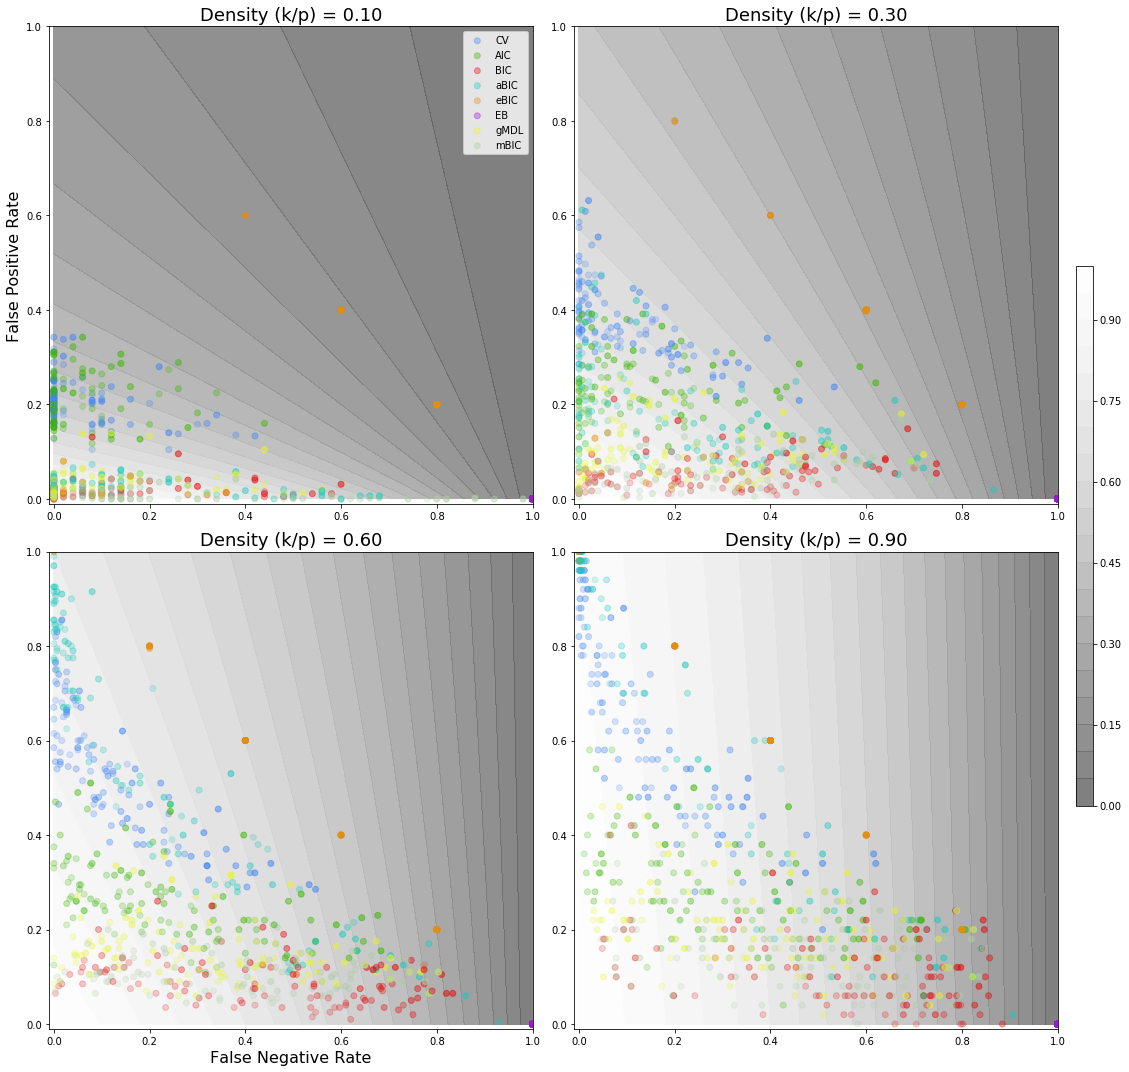

In [12]:
fig, ax = plt.subplots(2, 2, figsize = (15, 15))
scatters = []
n_features = 100
sparsity_ = [sparsity[0], sparsity[2], sparsity[5], sparsity[8]]
kappa_ = kappa

# Fix the betawidth, selection method, SNR
betawidth = np.inf

for i, s in enumerate(sparsity_):
    
    a = ax[np.unravel_index(i, (2, 2))]
    
    # Superimpose contours of constant selection accuracy
    xx = np.linspace(0, 1, 100)
    yy = np.linspace(0, 1, 100)
    z = np.zeros((100, 100))
    for ix, x in enumerate(xx):
        for iy, y in enumerate(yy):
            z[ix, iy] = 1 - ((1 - s)* y + s * x)/(s * (2 - x - y) + y) 
    
    cmap = plt.get_cmap('Greys_r')
    cmap_new = truncate_colormap(cmap, minval = 0.25)
    cs = a.contourf(xx, yy, z.T, 20, cmap = cmap_new, alpha = 0.75)

    # Set opacity via average correlation

    # Blue
    c1 = ['#4286f4', '#99bdf7', '#00aeff']
    # Green
    c2 = ['#3ab700', '#bae288', '#64821d']
    # Red
    c3 = ['#e50b0b', '#ef5f5f', '#70001d']
    # Cyan
    c4 = ['#1ec9be', '#d799ff', '#572677']
    # Orange
    c5 = ['#e38f12']
    # Purple
    c6 = ['#9b16d9']
    # Yellow
    c7 = ['#e6f725']
    # Dark, beige-green
    c8 = ['#b0cca7']
    
    colors_ = [c1, c2, c3, c4, c5, c6, c7, c8]
    color_permutation = [0, 1, 2, 3, 4, 5, 6, 7]
    
    for j, k in enumerate(kappa_):
        for ii, bw in enumerate([np.inf, -1, 0.1]):   
            
            # Filter by selection method
            cv_ = apply_df_filters(lasso, sparsity=s, selection_method='CV', kappa = k,
                                   betadict = {'betawidth': bw})
            AIC_ = apply_df_filters(lasso, sparsity=s, kappa=k, selection_method='AIC'
                                     , betadict = {'betawidth': bw})
            BIC_ = apply_df_filters(lasso, sparsity=s, kappa = k, selection_method= 'BIC'
                                   , betadict = {'betawidth': bw})
            aBIC_ = apply_df_filters(lasso, sparsity=s, kappa = k, selection_method='aBIC'
                                   , betadict = {'betawidth': bw})
            eBIC_ = apply_df_filters(lasso, sparsity = s, kappa = k, selection_method='eBIC'
                                    , betadict = {'betawidth': bw}) 
            eb_ = apply_df_filters(lasso, sparsity=s, kappa = k, selection_method='empirical_bayes'
                                   , betadict = {'betawidth': bw})
            gMDL_ = apply_df_filters(lasso, sparsity = s, kappa = k, selection_method='gMDL'
                                    , betadict = {'betawidth': bw}) 
            mBIC_ = apply_df_filters(lasso, sparsity = s, kappa = k, selection_method='mBIC'
                                    , betadict = {'betawidth': bw}) 
            dframes = [cv_, AIC_, BIC_, aBIC_, eBIC_, eb_, gMDL_, mBIC_]

            # Need to acquire the unique cov_params and then calculate the average covariance
            avg_covs = []
            FPR = []
            FNR = []
            for dframe in dframes:
                cov_params, rep_idxs = unique_cov_params(dframe)
                avg_covs.append([calc_avg_cov(n_features, **cp) for cp in cov_params])
                fnr_, fpr_ = average_fields(dframe, ['FNR', 'FPR'], rep_idxs)
                FPR.append(fpr_)
                FNR.append(fnr_)
                
            for i3 in range(len(dframes)):
                c = [colors.to_rgba(colors_[color_permutation[i3]][0], alpha = np.power(avgcov, 0.35))
                     for avgcov in avg_covs[i3]]
                scatters.append(a.scatter(FNR[i3], FPR[i3], c = c))
                        
    a.set_xlim([-0.01, 1])
    a.set_ylim([-0.01, 1])
    a.set_title('Density (k/p) = %.2f' % s, fontsize = 18)
    
ax[0, 0].set_ylabel('False Positive Rate', fontsize = 16)
ax[1, 0].set_xlabel('False Negative Rate', fontsize = 16)
ax[0, 0].legend(tuple(scatters[0:8]), ['CV', 'AIC', 'BIC', 'aBIC', 'eBIC', 'EB', 'gMDL', 'mBIC'])
cax = fig.add_axes([1, 0.25, 0.015, 0.5])
plt.colorbar(cs, cax = cax)
plt.tight_layout()
# plt.savefig('Lasso_selection_methods.pdf', bbox_inches ='tight', pad_inches=0)
# plt.savefig('fprvfnr_BIC.pdf', bbox_inches = 'tight', pad_inches=0)

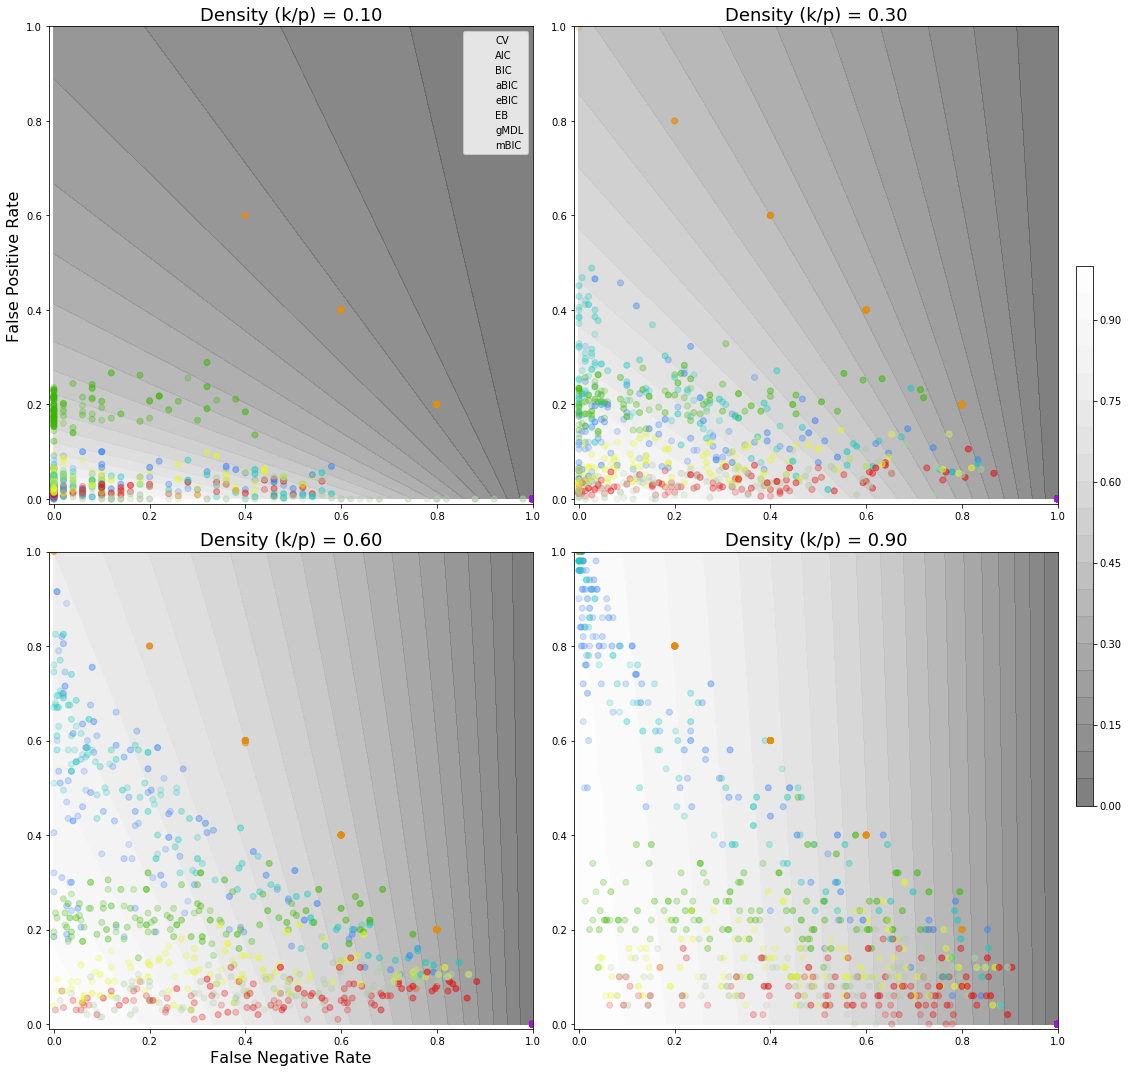

In [13]:
fig, ax = plt.subplots(2, 2, figsize = (15, 15))
scatters = []
n_features = 100
sparsity_ = [sparsity[0], sparsity[2], sparsity[5], sparsity[8]]
kappa_ = kappa

# Fix the betawidth, selection method, SNR
betawidth = np.inf

for i, s in enumerate(sparsity_):
    
    a = ax[np.unravel_index(i, (2, 2))]
    
    # Superimpose contours of constant selection accuracy
    xx = np.linspace(0, 1, 100)
    yy = np.linspace(0, 1, 100)
    z = np.zeros((100, 100))
    for ix, x in enumerate(xx):
        for iy, y in enumerate(yy):
            z[ix, iy] = 1 - ((1 - s)* y + s * x)/(s * (2 - x - y) + y) 
    
    cmap = plt.get_cmap('Greys_r')
    cmap_new = truncate_colormap(cmap, minval = 0.25)
    cs = a.contourf(xx, yy, z.T, 20, cmap = cmap_new, alpha = 0.75)

    # Set opacity via average correlation

    # Blue
    c1 = ['#4286f4', '#99bdf7', '#00aeff']
    # Green
    c2 = ['#3ab700', '#bae288', '#64821d']
    # Red
    c3 = ['#e50b0b', '#ef5f5f', '#70001d']
    # Cyan
    c4 = ['#1ec9be', '#d799ff', '#572677']
    # Orange
    c5 = ['#e38f12']
    # Purple
    c6 = ['#9b16d9']
    # Yellow
    c7 = ['#e6f725']
    # Dark, beige-green
    c8 = ['#b0cca7']
    
    colors_ = [c1, c2, c3, c4, c5, c6, c7, c8]
    color_permutation = [0, 1, 2, 3, 4, 5, 6, 7]
    
    for j, k in enumerate(kappa_):
        for ii, bw in enumerate([np.inf, -1, 0.1]):   
            
            # Filter by selection method
            cv_ = apply_df_filters(mcp, sparsity=s, selection_method='CV', kappa = k,
                                   betadict = {'betawidth': bw})
            AIC_ = apply_df_filters(mcp, sparsity=s, kappa=k, selection_method='AIC'
                                     , betadict = {'betawidth': bw})
            BIC_ = apply_df_filters(mcp, sparsity=s, kappa = k, selection_method= 'BIC'
                                   , betadict = {'betawidth': bw})
            aBIC_ = apply_df_filters(mcp, sparsity=s, kappa = k, selection_method='aBIC'
                                   , betadict = {'betawidth': bw})
            eBIC_ = apply_df_filters(mcp, sparsity = s, kappa = k, selection_method='eBIC'
                                    , betadict = {'betawidth': bw}) 
            eb_ = apply_df_filters(mcp, sparsity=s, kappa = k, selection_method='empirical_bayes'
                                   , betadict = {'betawidth': bw})
            gMDL_ = apply_df_filters(mcp, sparsity = s, kappa = k, selection_method='gMDL'
                                    , betadict = {'betawidth': bw}) 
            mBIC_ = apply_df_filters(mcp, sparsity = s, kappa = k, selection_method='mBIC'
                                    , betadict = {'betawidth': bw}) 
            dframes = [cv_, AIC_, BIC_, aBIC_, eBIC_, eb_, gMDL_, mBIC_]

            # Need to acquire the unique cov_params and then calculate the average covariance
            avg_covs = []
            FPR = []
            FNR = []
            for dframe in dframes:
                cov_params, rep_idxs = unique_cov_params(dframe)
                avg_covs.append([calc_avg_cov(n_features, **cp) for cp in cov_params])
                fnr_, fpr_ = average_fields(dframe, ['FNR', 'FPR'], rep_idxs)
                FPR.append(fpr_)
                FNR.append(fnr_)
                
            for i3 in range(len(dframes)):
                c = [colors.to_rgba(colors_[color_permutation[i3]][0], alpha = np.power(avgcov, 0.35))
                     for avgcov in avg_covs[i3]]
                scatters.append(a.scatter(FNR[i3], FPR[i3], c = c))
                        
    a.set_xlim([-0.01, 1])
    a.set_ylim([-0.01, 1])
    a.set_title('Density (k/p) = %.2f' % s, fontsize = 18)
    
ax[0, 0].set_ylabel('False Positive Rate', fontsize = 16)
ax[1, 0].set_xlabel('False Negative Rate', fontsize = 16)
ax[0, 0].legend(tuple(scatters[0:8]), ['CV', 'AIC', 'BIC', 'aBIC', 'eBIC', 'EB', 'gMDL', 'mBIC'])
cax = fig.add_axes([1, 0.25, 0.015, 0.5])
plt.colorbar(cs, cax = cax)
plt.tight_layout()
# plt.savefig('mcp_selection_methods.pdf', bbox_inches ='tight', pad_inches=0)
# plt.savefig('fprvfnr_BIC.pdf', bbox_inches = 'tight', pad_inches=0)

## Selection Accuracy curves

In [ ]:
# Marginalize over the sparsity and plot the selection accuracy rates

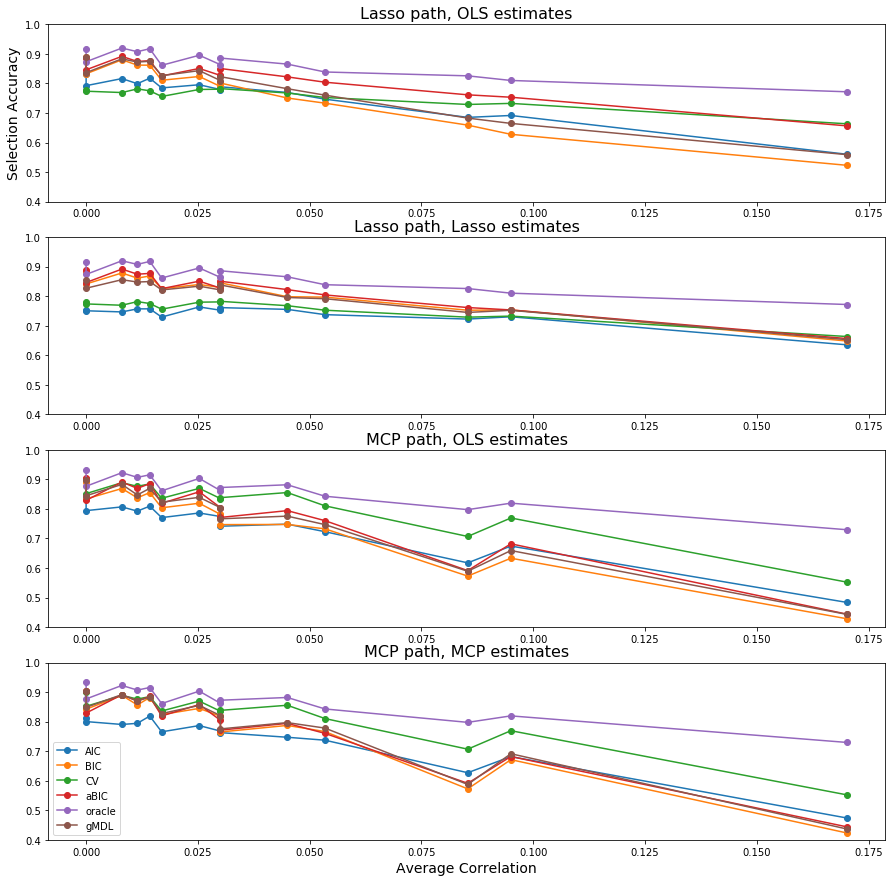

In [98]:
fig, ax = plt.subplots(4, 1, figsize = (15, 15))

# Pull out all the distinct selection_methods

selection_methods = ['AIC', 'BIC', 'CV', 'aBIC', 'gMDL']

drames = []

for sm in selection_methods:
    df = apply_df_filters(lasso, kappa=5, selection_method=sm, 
                                    betadict = {'betawidth' : np.inf})
    asa, c = averaged_field(df, 100)
    ax[0].plot(c, asa, '-o')
    
    if sm == 'aBIC':
        osa, c = averaged_field(df, 100, field='oracle_sa')
        ax[0].plot(c, osa, '-o')
ax[0].set_ylim([0.4, 1])
ax[0].set_title('Lasso path, OLS estimates', fontsize=16)
    
for sm in selection_methods:
    df = apply_df_filters(lasso_notOLS, kappa=5, selection_method=sm, 
                                    betadict = {'betawidth' : np.inf})
    asa, c = averaged_field(df, 100)
    ax[1].plot(c, asa, '-o')
    
    if sm == 'aBIC':
        osa, c = averaged_field(df, 100, field='oracle_sa')
        ax[1].plot(c, osa, '-o')

ax[1].set_ylim([0.4, 1])    
ax[1].set_title('Lasso path, Lasso estimates', fontsize = 16)
    
for sm in selection_methods:
    df = apply_df_filters(mcp, kappa=5, selection_method=sm, 
                                    betadict = {'betawidth' : np.inf})
    asa, c = averaged_field(df, 100)
    ax[2].plot(c, asa, '-o')

    if sm == 'aBIC':
        osa, c = averaged_field(df, 100, field='oracle_sa')
        ax[2].plot(c, osa, '-o')

ax[2].set_ylim([0.4, 1])
ax[2].set_title('MCP path, OLS estimates', fontsize = 16)
    
for sm in selection_methods:
    df = apply_df_filters(mcp_notOLS, kappa=5, selection_method=sm, 
                                    betadict = {'betawidth' : np.inf})
    asa, c = averaged_field(df, 100)
    ax[3].plot(c, asa, '-o')
    
    if sm == 'aBIC':
        osa, c = averaged_field(df, 100, field='oracle_sa')
        ax[3].plot(c, osa, '-o')

ax[3].set_ylim([0.4, 1])
ax[3].set_title('MCP path, MCP estimates', fontsize=16)
ax[3].set_xlabel('Average Correlation', fontsize=14)
ax[0].set_ylabel('Selection Accuracy', fontsize=14)
        
        
selection_methods.insert(4, 'oracle')
ax[3].legend(selection_methods)


plt.savefig('sm1_fullsparsity.pdf', bbox_inches='tight', pad_inches=0)

In [ ]:
# Limit to sparse cases

(700, 32)
(700, 32)
(700, 32)
(700, 32)
(700, 32)


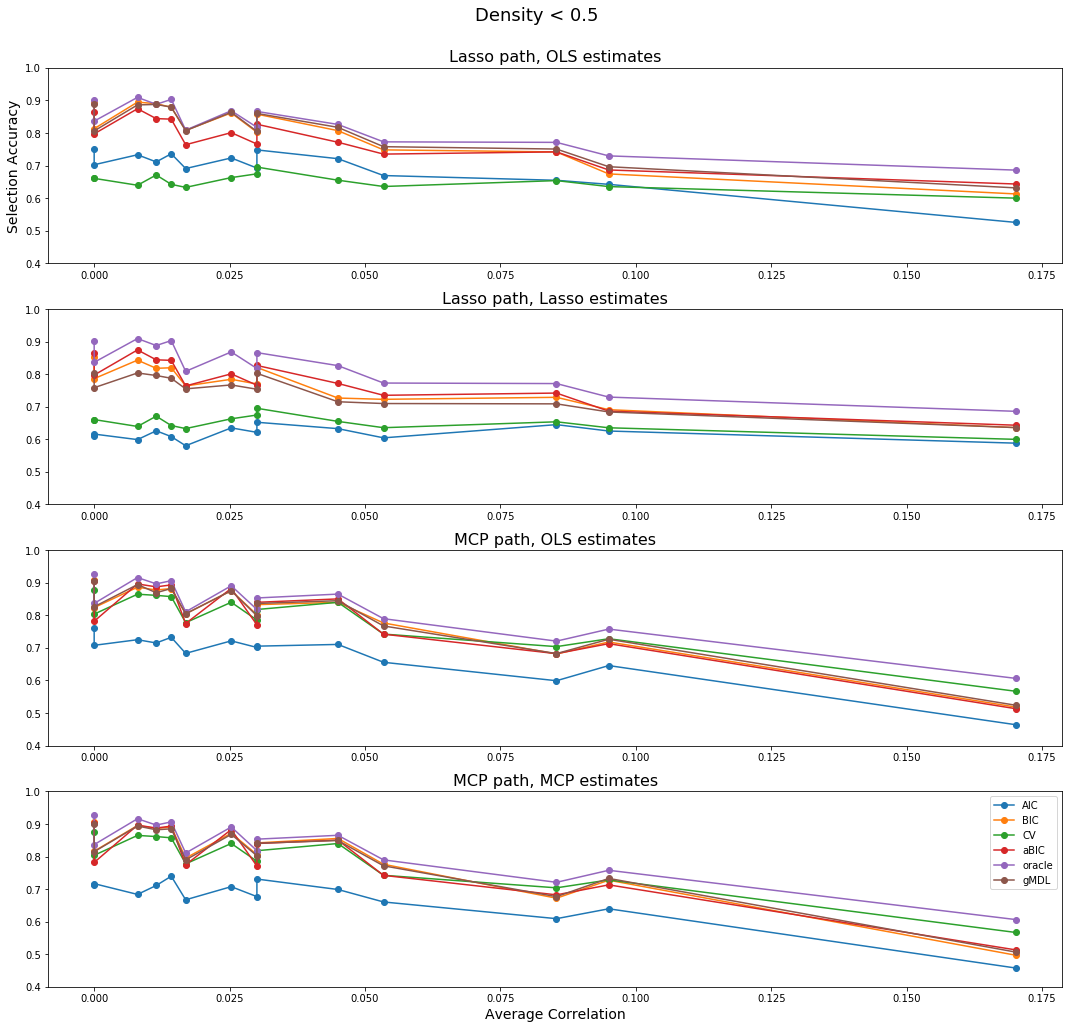

In [133]:
fig, ax = plt.subplots(4, 1, figsize = (15, 15))

# Pull out all the distinct selection_methods

selection_methods = ['AIC', 'BIC', 'CV', 'aBIC', 'gMDL']

drames = []

for sm in selection_methods:
    df = apply_df_filters(lasso, kappa=5, selection_method=sm, 
                                    betadict = {'betawidth' : np.inf})
    print(df.shape)
    asa, c = averaged_field(df, 100, sparsity_cutoff=0.5)
    
    ax[0].plot(c, asa, '-o')

    if sm == 'aBIC':
        osa, c = averaged_field(df, 100, field='oracle_sa', sparsity_cutoff=0.5)
        ax[0].plot(c, osa, '-o')
    
ax[0].set_ylim([0.4, 1])
ax[0].set_title('Lasso path, OLS estimates', fontsize=16)
    
for sm in selection_methods:
    df = apply_df_filters(lasso_notOLS, kappa=5, selection_method=sm, 
                                    betadict = {'betawidth' : np.inf})
    asa, c = averaged_field(df, 100, sparsity_cutoff=0.5)
    ax[1].plot(c, asa, '-o')
    if sm == 'aBIC':
        osa, c = averaged_field(df, 100, field='oracle_sa', sparsity_cutoff=0.5)
        ax[1].plot(c, osa, '-o')

ax[1].set_ylim([0.4, 1])    
ax[1].set_title('Lasso path, Lasso estimates', fontsize = 16)

for sm in selection_methods:
    df = apply_df_filters(mcp, kappa=5, selection_method=sm, 
                                    betadict = {'betawidth' : np.inf})
    asa, c = averaged_field(df, 100, sparsity_cutoff=0.5)
    ax[2].plot(c, asa, '-o')
    if sm == 'aBIC':
        osa, c = averaged_field(df, 100, field='oracle_sa', sparsity_cutoff=0.5)
        ax[2].plot(c, osa, '-o')

ax[2].set_ylim([0.4, 1])
ax[2].set_title('MCP path, OLS estimates', fontsize = 16)
        
for sm in selection_methods:
    df = apply_df_filters(mcp_notOLS, kappa=5, selection_method=sm, 
                                    betadict = {'betawidth' : np.inf})
    asa, c = averaged_field(df, 100, sparsity_cutoff=0.5)
    ax[3].plot(c, asa, '-o')
    if sm == 'aBIC':
        osa, c = averaged_field(df, 100, field='oracle_sa', sparsity_cutoff=0.5)
        ax[3].plot(c, osa, '-o')

ax[3].set_ylim([0.4, 1])
ax[3].set_title('MCP path, MCP estimates', fontsize=16)
ax[3].set_xlabel('Average Correlation', fontsize=14)
ax[0].set_ylabel('Selection Accuracy', fontsize=14)
                
selection_methods.insert(4, 'oracle')
ax[3].legend(selection_methods)

fig.suptitle('Density < 0.5', fontsize=18)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('restricted_sparsity.pdf', bbox_inches='tight', pad_inches=0)

## Effective penalty heatmaps

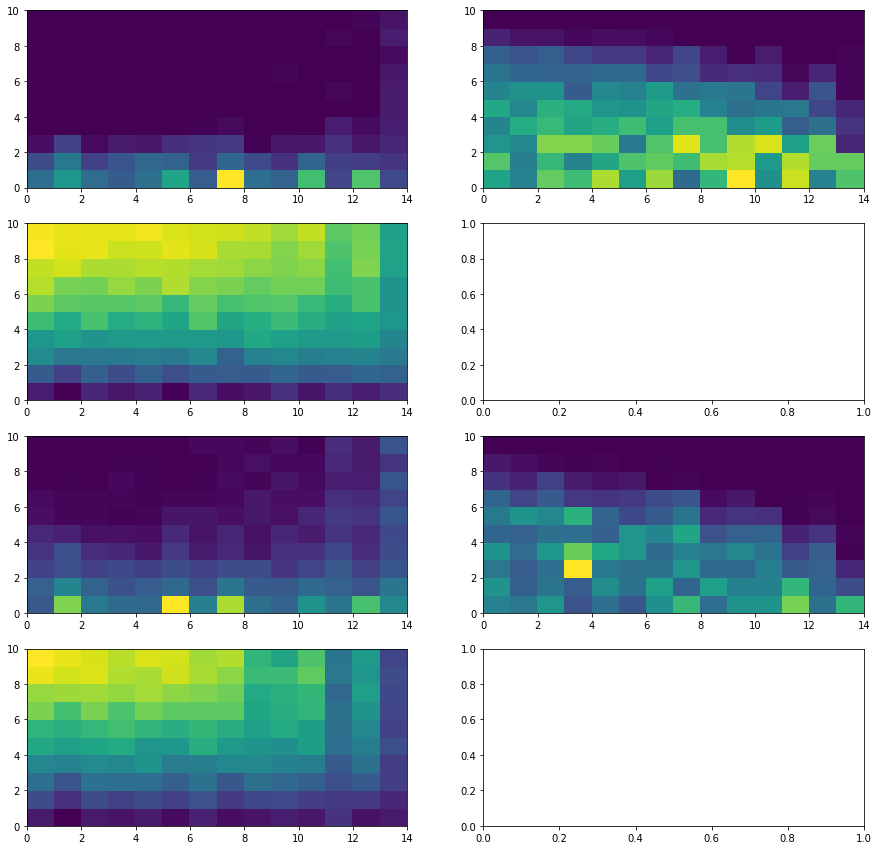

In [58]:
fig, ax = plt.subplots(4, 2, figsize = (15, 15))

# This guy you want as a heatmap
    
for sm in ['aBIC']:
    df = apply_df_filters(lasso_notOLS, kappa=5, selection_method=sm, 
                                    betadict = {'betawidth' : np.inf})
    effp, c = averaged_field_heatmap(df, 100, field='effective_penalty')
    op, c = averaged_field_heatmap(df, 100, field='oracle_penalty')
    ax[0, 0].pcolormesh(effp)
    ax[0, 1].pcolormesh(op)
    
for sm in ['gMDL']:
    df = apply_df_filters(lasso_notOLS, kappa=5, selection_method=sm, 
                                    betadict = {'betawidth' : np.inf})
    effp, c = averaged_field_heatmap(df, 100, field='effective_penalty')
    ax[1, 0].pcolormesh(effp)
    
for sm in ['aBIC']:
    df = apply_df_filters(mcp_notOLS, kappa=5, selection_method=sm, 
                                    betadict = {'betawidth' : np.inf})
    effp, c = averaged_field_heatmap(df, 100, field='effective_penalty')
    op, c = averaged_field_heatmap(df, 100, field='oracle_penalty')
    ax[2, 0].pcolormesh(effp)
    ax[2, 1].pcolormesh(op)

for sm in ['gMDL']:
    df = apply_df_filters(mcp_notOLS, kappa=5, selection_method=sm, 
                                    betadict = {'betawidth' : np.inf})
    effp, c = averaged_field_heatmap(df, 100, field='effective_penalty')
    ax[3, 0].pcolormesh(effp)
    
# What is going on with gMDL's effective penalty?

# MCP for sparsity estimation

## Selection accuracy curves

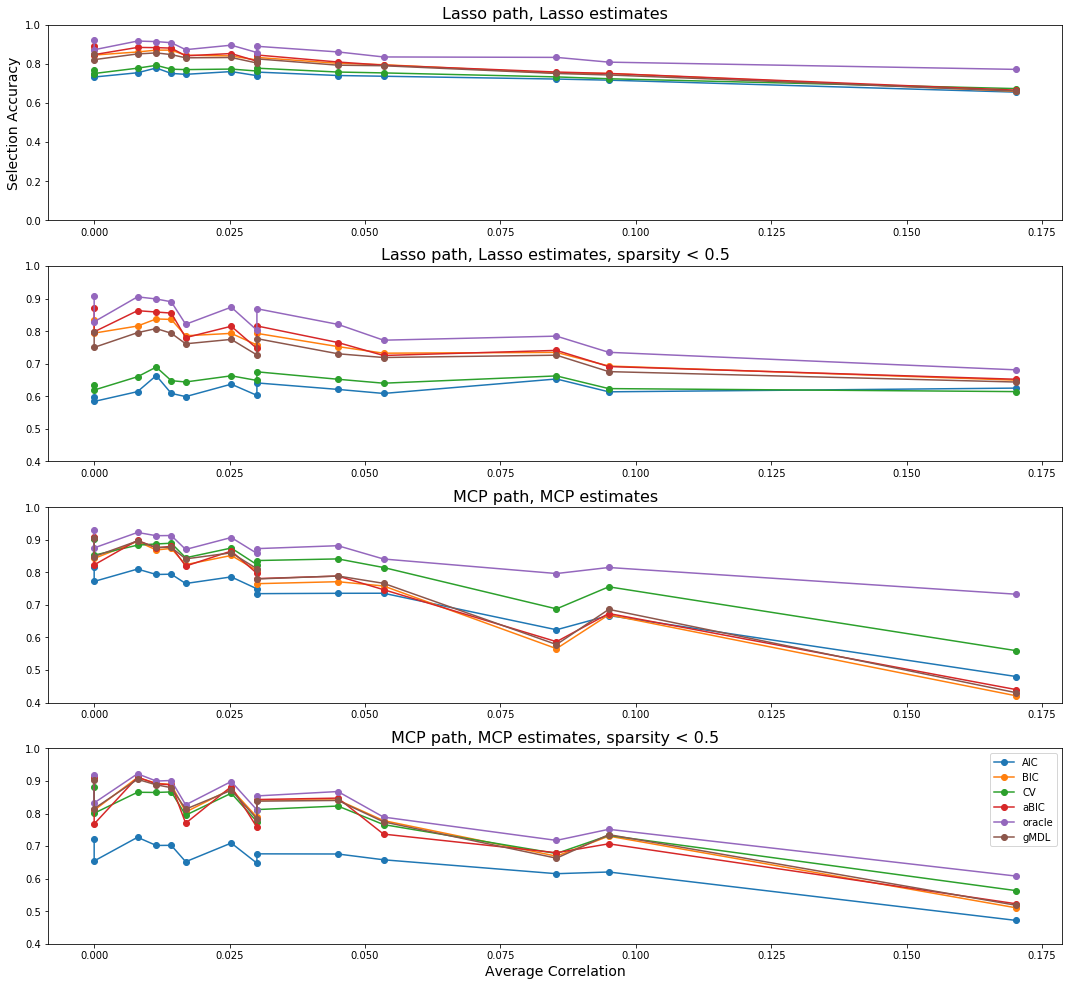

In [21]:
fig, ax = plt.subplots(4, 1, figsize = (15, 15))

# Pull out all the distinct selection_methods

sm1 = ['AIC', 'BIC', 'CV']
sm2 = ['aBIC', 'gMDL']

drames = []

for sm in sm1:
    df = apply_df_filters(lasso_notOLS, kappa=5, selection_method=sm, 
                                    betadict = {'betawidth' : np.inf})
    asa, c = averaged_field(df, 100)
    ax[0].plot(c, asa, '-o')
    
for sm in sm2:
    df = apply_df_filters(lasso2, kappa=5, selection_method=sm,
                          betadict = {'betawidth' : np.inf})

    asa, c = averaged_field(df, 100)
    ax[0].plot(c, asa, '-o')
    
    if sm == 'aBIC':
        osa, c = averaged_field(df, 100, field='oracle_sa')
        ax[0].plot(c, osa, '-o')

ax[0].set_ylim([0, 1])
ax[0].set_title('Lasso path, Lasso estimates', fontsize = 16)
        
    
for sm in sm1:
    df = apply_df_filters(lasso_notOLS, kappa=5, selection_method=sm, 
                                    betadict = {'betawidth' : np.inf})
    asa, c = averaged_field(df, 100, sparsity_cutoff=0.5)
    ax[1].plot(c, asa, '-o')
    
for sm in sm2:
    df = apply_df_filters(lasso2, kappa=5, selection_method=sm,
                          betadict = {'betawidth' : np.inf})

    asa, c = averaged_field(df, 100, sparsity_cutoff=0.5)
    ax[1].plot(c, asa, '-o')
    
    if sm == 'aBIC':
        osa, c = averaged_field(df, 100, field='oracle_sa', sparsity_cutoff=0.5)
        ax[1].plot(c, osa, '-o')
        
ax[1].set_ylim([0.4, 1])    
ax[1].set_title('Lasso path, Lasso estimates, sparsity < 0.5', fontsize = 16)
    
for sm in sm1:
    df = apply_df_filters(mcp_notOLS, kappa=5, selection_method=sm, 
                                    betadict = {'betawidth' : np.inf})
    asa, c = averaged_field(df, 100)
    ax[2].plot(c, asa, '-o')
    
for sm in sm2:
    df = apply_df_filters(mcp2, kappa=5, selection_method=sm,
                          betadict = {'betawidth' : np.inf})

    asa, c = averaged_field(df, 100)
    ax[2].plot(c, asa, '-o')
    
    if sm == 'aBIC':
        osa, c = averaged_field(df, 100, field='oracle_sa')
        ax[2].plot(c, osa, '-o')
        
ax[2].set_ylim([0.4, 1])
ax[2].set_title('MCP path, MCP estimates', fontsize = 16)
    
for sm in sm1:
    df = apply_df_filters(mcp_notOLS, kappa=5, selection_method=sm, 
                                    betadict = {'betawidth' : np.inf})
    asa, c = averaged_field(df, 100, sparsity_cutoff=0.5)
    ax[3].plot(c, asa, '-o')
    
for sm in sm2:
    df = apply_df_filters(mcp2, kappa=5, selection_method=sm,
                          betadict = {'betawidth' : np.inf})

    asa, c = averaged_field(df, 100, sparsity_cutoff=0.5)
    ax[3].plot(c, asa, '-o')
    
    if sm == 'aBIC':
        osa, c = averaged_field(df, 100, field='oracle_sa', sparsity_cutoff=0.5)
        ax[3].plot(c, osa, '-o')
    
    
ax[3].set_ylim([0.4, 1])
ax[3].set_title('MCP path, MCP estimates, sparsity < 0.5', fontsize=16)
ax[3].set_xlabel('Average Correlation', fontsize=14)
ax[0].set_ylabel('Selection Accuracy', fontsize=14)
        
sm1.extend(sm2)    
sm1.insert(4, 'oracle')
ax[3].legend(sm1)

fig.suptitle('', fontsize=18)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('sm2_sa.pdf', bbox_inches='tight', pad_inches=0)

In [ ]:
# High dimensional setting seems to be a salient regime missing from our simulations

In [ ]:
# Recast "effective penalty" as the ratio between the gof and complexity terms

In [ ]:
# raw penalties

In [124]:
np.array(c).shape

(10, 14)

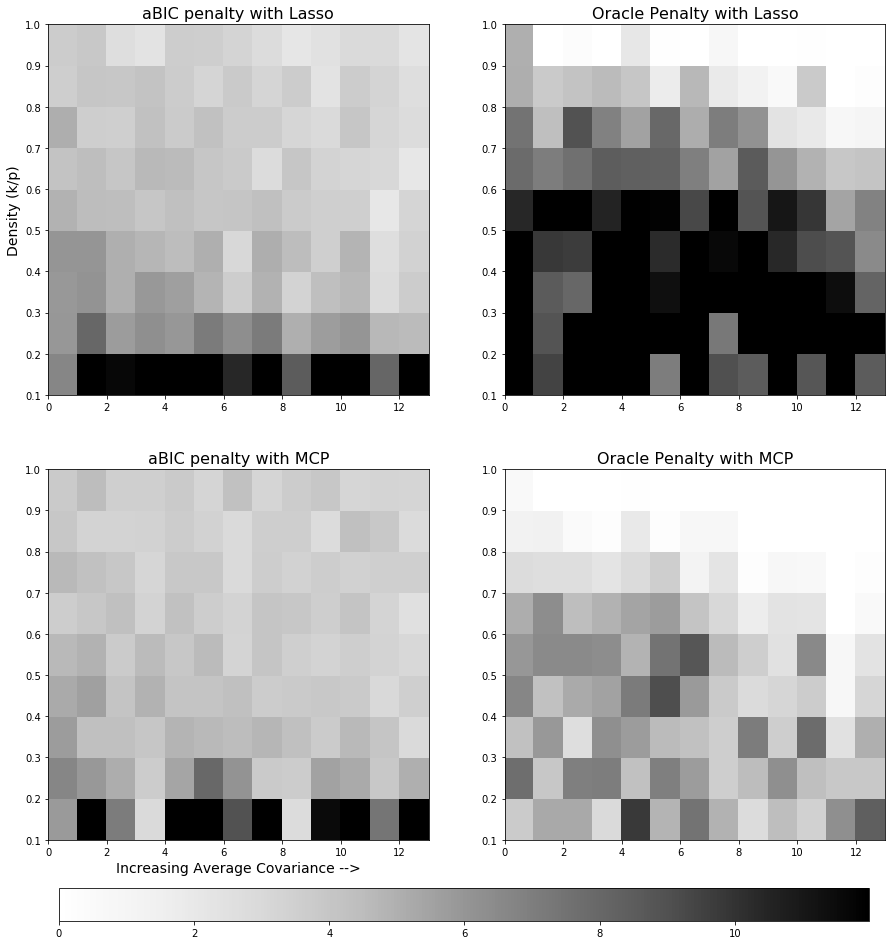

In [21]:
fig, ax = plt.subplots(2, 2, figsize = (15, 15))

# This guy you want as a heatmap
    
for sm in ['aBIC']:
    df = apply_df_filters(lasso_notOLS, kappa=5, selection_method=sm, 
                                    betadict = {'betawidth' : np.inf})
    effp, c = averaged_field_heatmap(df, 100, field='effective_penalty')
    op, c = averaged_field_heatmap(df, 100, field='oracle_penalty')
    ax[0, 0].pcolormesh(np.arange(14), sparsity, np.array(effp), cmap='Greys', vmin=0, vmax= 2*np.log(400))
    ax[0, 1].pcolormesh(np.arange(14), sparsity, np.array(op), cmap='Greys', vmin=0, vmax= 2*np.log(400))
            
ax[0, 0].set_ylabel('Density (k/p)', fontsize = 14)
ax[0, 0].set_title('aBIC penalty with Lasso', fontsize = 16)
ax[0, 1].set_title('Oracle Penalty with Lasso', fontsize = 16)
        
for sm in ['aBIC']:
    df = apply_df_filters(mcp_notOLS, kappa=5, selection_method=sm, 
                                    betadict = {'betawidth' : np.inf})
    effp, c = averaged_field_heatmap(df, 100, field='effective_penalty')
    op, c = averaged_field_heatmap(df, 100, field='oracle_penalty')
    ax[1, 0].pcolormesh(np.arange(14), sparsity, np.array(effp), cmap='Greys', vmin=0, vmax= 2*np.log(400))
    h = ax[1, 1].pcolormesh(np.arange(14), sparsity, np.array(op), cmap='Greys', vmin=0, vmax= 2*np.log(400))

ax[1, 0].set_xlabel('Increasing Average Covariance -->', fontsize = 14)
ax[1, 0].set_title('aBIC penalty with MCP', fontsize = 16)
ax[1, 1].set_title('Oracle Penalty with MCP', fontsize = 16)

cbaxes = fig.add_axes([0.135, 0.05, 0.75, 0.03]) 
cb = fig.colorbar(h, cax = cbaxes, orientation="horizontal")
plt.savefig('real_penalties.pdf', bbox_inches='tight', pad_inches=0)

## Effective Penalties

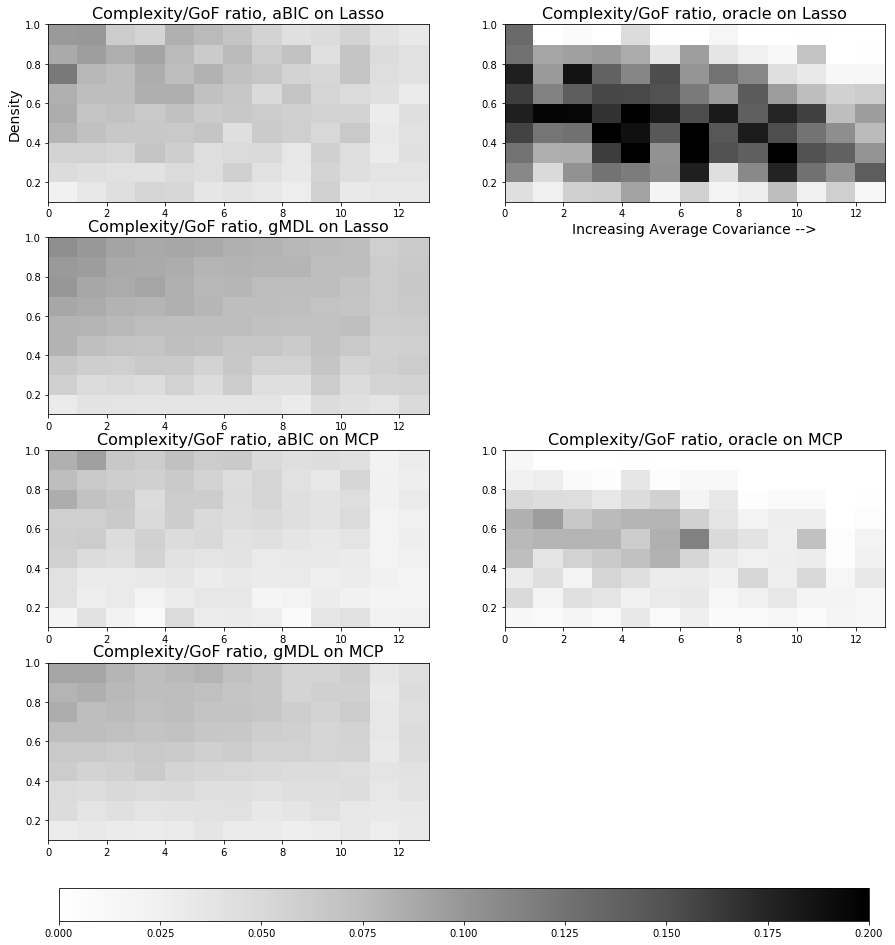

In [20]:
fig, ax = plt.subplots(4, 2, figsize = (15, 15))

# This guy you want as a heatmap
    
for sm in ['aBIC']:
    df = apply_df_filters(lasso_notOLS, kappa=5, selection_method=sm, 
                                    betadict = {'betawidth' : np.inf})
    effp, c = averaged_effpenalty(df, 100, field='effective_penalty')
    op, c = averaged_effpenalty(df, 100, field='oracle_penalty')
    ax[0, 0].pcolormesh(np.arange(14), sparsity, np.abs(np.array(effp)), cmap = 'Greys', vmin = 0, vmax = 0.2)
    ax[0, 1].pcolormesh(np.arange(14), sparsity, np.abs(np.array(op)), cmap = 'Greys', vmin = 0, vmax = 0.2)

ax[0, 0].set_title('Complexity/GoF ratio, aBIC on Lasso', fontsize=16)
ax[0, 0].set_ylabel('Density', fontsize = 14)
ax[0, 1].set_title('Complexity/GoF ratio, oracle on Lasso', fontsize=16)
ax[0, 1].set_xlabel('Increasing Average Covariance -->', fontsize=14)

for sm in ['gMDL']:
    df = apply_df_filters(lasso_notOLS, kappa=5, selection_method=sm, 
                                    betadict = {'betawidth' : np.inf})
    effp, c = averaged_field_heatmap(df, 100, field='effective_penalty')
    ax[1, 0].pcolormesh(np.arange(14), sparsity, np.power(np.abs(effp), -1), cmap = 'Greys', vmin = 0, vmax = 0.2)
ax[1, 0].set_title('Complexity/GoF ratio, gMDL on Lasso', fontsize=16)
    
    
for sm in ['aBIC']:
    df = apply_df_filters(mcp_notOLS, kappa=5, selection_method=sm, 
                                    betadict = {'betawidth' : np.inf})
    effp, c = averaged_effpenalty(df, 100, field='effective_penalty')
    op, c = averaged_effpenalty(df, 100, field='oracle_penalty')
    ax[2, 0].pcolormesh(np.arange(14), sparsity, np.abs(effp), cmap = 'Greys', vmin = 0, vmax = 0.2)
    ax[2, 1].pcolormesh(np.arange(14), sparsity, np.abs(op), cmap = 'Greys', vmin = 0, vmax = 0.2)

ax[2, 0].set_title('Complexity/GoF ratio, aBIC on MCP', fontsize=16)
ax[2, 1].set_title('Complexity/GoF ratio, oracle on MCP', fontsize=16)

    
for sm in ['gMDL']:
    df = apply_df_filters(mcp_notOLS, kappa=5, selection_method=sm, 
                                    betadict = {'betawidth' : np.inf})
    effp, c = averaged_field_heatmap(df, 100, field='effective_penalty')
    h = ax[3, 0].pcolormesh(np.arange(14), sparsity, np.power(np.abs(effp), -1), cmap = 'Greys', vmin = 0, vmax = 0.2)

ax[3, 0].set_title('Complexity/GoF ratio, gMDL on MCP', fontsize=16)
    
    
plt.delaxes(ax[1, 1])
plt.delaxes(ax[3, 1])
    
cbaxes = fig.add_axes([0.135, 0.05, 0.75, 0.03]) 
cb = fig.colorbar(h, cax = cbaxes, orientation="horizontal")
plt.savefig('effective_penalty.pdf', bbox_inches='tight', pad_inches=0)

## Sparsity Estimates

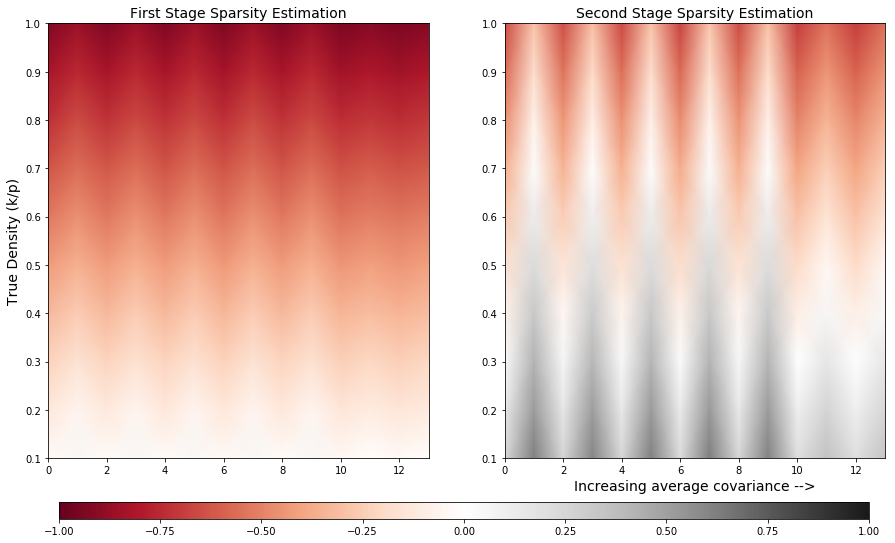

In [25]:
# Sparsity estimates: How to visualize? --> heatmap of true sparsity vs. average correlation, plotting
# true sparsity - estimated sparsity

# Use gouraud shading, greys colormap, and consistent colorscale

fig, ax = plt.subplots(1, 2, figsize = (15, 8))
    
for sm in ['aBIC']:
    df = apply_df_filters(lasso, kappa=5, selection_method=sm, 
                                    betadict = {'betawidth' : np.inf})

    # Plot 1st stage and second stage sparsity estimation
    se0, se1 = average_sparsity_estimates(df, 100)
    true_sparsity = np.tile(sparsity[:, np.newaxis], (1, 14))
    
    ax[0].pcolormesh(np.arange(14), sparsity, se0 - true_sparsity, cmap ='RdGy', vmin =-1, vmax = 1, shading ='gouraud')
    h = ax[1].pcolormesh(np.arange(14), sparsity, se1 - true_sparsity, cmap = 'RdGy', vmin =-1, vmax =1, shading='gouraud')

    ax[0].set_title('First Stage Sparsity Estimation', fontsize=14)
    ax[1].set_title('Second Stage Sparsity Estimation', fontsize=14)
    
# for sm in ['aBIC']:
#     df = apply_df_filters(lasso2, kappa=5, selection_method=sm, 
#                                     betadict = {'betawidth' : np.inf})
#     # Plot 1st stage and second stage sparsity estimation
#     se0, se1 = average_sparsity_estimates(df, 100)
#     true_sparsity = np.tile(sparsity[:, np.newaxis], (1, 14))
    
#     ax[1, 0].pcolormesh(se0 - true_sparsity, cmap ='RdGy', vmin =-1, vmax = 1, shading ='gouraud')
#     h = ax[1, 1].pcolormesh(se1 - true_sparsity, cmap ='RdGy', vmin =-1, vmax = 1, shading ='gouraud')

#     ax[0, 0].set_title('First Stage Sparsity Estimation (using MCP)', fontsize=14)
#     ax[0, 1].set_title('Second Stage Sparsity Estimation (using MCP)', fontsize=14)

ax[0].set_ylabel('True Density (k/p)', fontsize=14)
ax[1].set_xlabel('Increasing average covariance -->', fontsize=14)

# Now adding the colorbar
cbaxes = fig.add_axes([0.135, 0.02, 0.75, 0.03]) 
cb = fig.colorbar(h, cax = cbaxes, orientation="horizontal")
plt.savefig('sparsity_estimates.pdf', bbox_inches='tight', pad_inches=0)

In [ ]:
# Now all that is left to do is the stability selection visualization!